In [6]:
data = "../../coral_img/"

In [7]:
# Imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import numpy
import math
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, merge
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
import keras.backend as K
from natsort import natsorted, ns
import keras
import PIL
from keras.regularizers import l2
from glob import glob
from keras.applications import vgg16
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from matplotlib import pyplot
import tensorflow as tf
from sklearn.model_selection import train_test_split

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [8]:
def brightness_fix(img):
    img_blur = cv2.GaussianBlur(img, (5, 5), 0)
    img_RGB = cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB)
    img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    cl1 = clahe.apply(img_YCrCb[:,:,0])
    
    img_YCrCb[:,:,0] = cl1 
    
    img_RGB_2 = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    
    return img_RGB_2

In [9]:
# Fijar las semillas
seed = 2032 # Semilla del numpy
tf.set_random_seed(seed)# Fijar semilla del keras/tensorflow

epochs = 1000
batch_size = 32

model_name = 'model.h5'

In [10]:
# Train and test directories
train_dir = data + "train/"
test_dir = data + "Test_Mixed/"

In [11]:
# Classes
clases = sorted(os.listdir(train_dir))
print(clases)

x_train = np.array([brightness_fix(cv2.imread(os.path.join(train_dir, cl, name), cv2.IMREAD_COLOR)) for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])
y_lab = np.array([n for n, cl in enumerate(clases)
           for name in os.listdir(os.path.join(train_dir, cl))])

idx = np.random.permutation(len(x_train))
x_train, y_lab = x_train[idx], y_lab[idx]

test_files = natsorted(os.listdir(test_dir))

x_test = np.array([brightness_fix(cv2.imread(os.path.join(test_dir, name), cv2.IMREAD_COLOR)) 
                   for name in test_files])

['ACER', 'APAL', 'CNAT', 'DANT', 'DSTR', 'GORG', 'MALC', 'MCAV', 'MMEA', 'MONT', 'PALY', 'SPO', 'SSID', 'TUNI']


In [12]:

x_train = x_train.astype('float32')
x_train /= 255

x_test = x_test.astype('float32')
x_test /= 255

y_train = to_categorical(y_lab, dtype=int)

x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,stratify=y_train,test_size=0.1, random_state = 69)

print(x_train.shape)
print(len(clases))
print(y_train.shape)

(558, 256, 256, 3)
14
(558, 14)


In [13]:
datagen = ImageDataGenerator(
    featurewise_center = True,
    #shear_range=0.05,
    zoom_range=0.4,
    horizontal_flip=True,   
)

datagen_val = ImageDataGenerator(
    samplewise_center = True,
)

datagen.fit(x_train)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = datagen_val.flow(x_validation, y_validation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


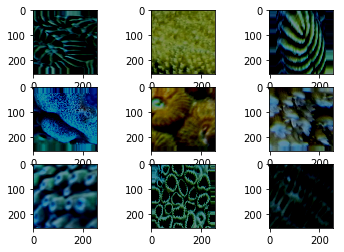

In [14]:
#os.makedirs('images')

for X_batch, y_batch in datagen.flow(x_train, y_train):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i])
    pyplot.show()
    break

In [15]:
# create the base pre-trained model
base_model = vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(256,256,3))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [17]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(rate=0.25)(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(rate=0.5)(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(14,activation='softmax')(x) 

model=Model(inputs=base_model.input, outputs=preds)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dropout_1
21 dense_1
22 dropout_2
23 dense_2
24 dense_3


In [19]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers[:11]:
    layer.trainable=False
for layer in model.layers[11:]:
    layer.trainable=True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10)

In [21]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(train_generator,
                   steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                   validation_data = val_generator,
                   validation_steps = len(x_validation) / batch_size,
                   verbose=1, callbacks=[es])

model.save(model_name)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
18/17 [==============================] - 9s 479ms/step - loss: 2.7366 - acc: 0.0856 - val_loss: 2.6055 - val_acc: 0.0968
Epoch 2/1000
18/17 [==============================] - 3s 157ms/step - loss: 2.6200 - acc: 0.1082 - val_loss: 2.4826 - val_acc: 0.1452
Epoch 3/1000
18/17 [==============================] - 3s 193ms/step - loss: 2.5427 - acc: 0.1559 - val_loss: 2.3385 - val_acc: 0.2258
Epoch 4/1000
18/17 [==============================] - 4s 241ms/step - loss: 2.4018 - acc: 0.1893 - val_loss: 2.1631 - val_acc: 0.4032
Epoch 5/1000
18/17 [==============================] - 4s 240ms/step - loss: 2.2266 - acc: 0.2697 - val_loss: 1.9484 - val_acc: 0.4677
Epoch 6/1000
18/17 [==============================] - 4s 239ms/step - loss: 2.0722 - acc: 0.3396 - val_loss: 1.7756 - val_acc: 0.5484
Epoch 7/1000
18/17 [==============================] - 4s 240ms/step - loss: 1.8676 - acc: 0.4152 - val_loss: 1.5469 - val_acc: 0.6129
Epoch 8/1000
1

Epoch 60/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.0987 - acc: 0.9670 - val_loss: 0.3507 - val_acc: 0.8710
Epoch 61/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.1498 - acc: 0.9492 - val_loss: 0.1717 - val_acc: 0.9032
Epoch 62/1000
18/17 [==============================] - 5s 265ms/step - loss: 0.1124 - acc: 0.9635 - val_loss: 0.3466 - val_acc: 0.8548
Epoch 63/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.0935 - acc: 0.9739 - val_loss: 0.3655 - val_acc: 0.9194
Epoch 64/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.0901 - acc: 0.9652 - val_loss: 0.3069 - val_acc: 0.8548
Epoch 65/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.1077 - acc: 0.9648 - val_loss: 0.3280 - val_acc: 0.8710
Epoch 66/1000
18/17 [==============================] - 5s 264ms/step - loss: 0.0745 - acc: 0.9774 - val_loss: 0.2142 - val_acc: 0.9194
Epoch 67/1000
18/17 [==============================] - 

In [23]:
x_test = datagen.standardize(x_test)
predictions_test = model.predict(x_test, verbose=1)

data = pd.DataFrame()
data['Id'] = test_files
data['Category'] = predictions_test.argmax(axis=-1)


data.to_csv("envio.csv", index=False)

146/146 [==============================] - 1s 10ms/step


In [24]:
conversion = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13
}
classes = []
for t in test_files:
  class_ = t.split("T")[0]
  classes.append(conversion[class_])

from sklearn.metrics import accuracy_score
print(accuracy_score(classes, data['Category']))

0.958904109589041
